In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

### Bootstrap data splitting for estimating prediction error

#### Example: `auto` data

In [161]:
auto = (
    pd.read_csv("../data/auto.csv", na_values=["?"], dtype={"origin": "category"})
    .drop(columns=["name"])
    .dropna()
    .reset_index(drop=True)
)

origin = auto.pop("origin")
auto["european"] = origin == "2"
auto["japanese"] = origin == "3"
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,european,japanese
0,18.0,8,307.0,130.0,3504,12.0,70,False,False
1,15.0,8,350.0,165.0,3693,11.5,70,False,False
2,18.0,8,318.0,150.0,3436,11.0,70,False,False
3,16.0,8,304.0,150.0,3433,12.0,70,False,False
4,17.0,8,302.0,140.0,3449,10.5,70,False,False
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790,15.6,82,False,False
388,44.0,4,97.0,52.0,2130,24.6,82,True,False
389,32.0,4,135.0,84.0,2295,11.6,82,False,False
390,28.0,4,120.0,79.0,2625,18.6,82,False,False


In [3]:
def bootstrap_split(random_state=None):
    train = auto.sample(frac=1, replace=True, random_state=random_state)
    train_mpg = train.pop("mpg")
    train_mask = auto.index.isin(train.index)
    test = auto[~train_mask]
    test_mpg = test.pop("mpg")
    return train, test, train_mpg, test_mpg

In [4]:
r = 1000

train_errs = np.zeros(r)
test_errs = np.zeros(r)

model = LinearRegression()

for i in range(r):
    X_train, X_test, y_train, y_test = bootstrap_split()
    model.fit(X_train, y_train)
    train_errs[i] = mean_squared_error(y_train, model.predict(X_train))
    test_errs[i] = mean_squared_error(y_test, model.predict(X_test))

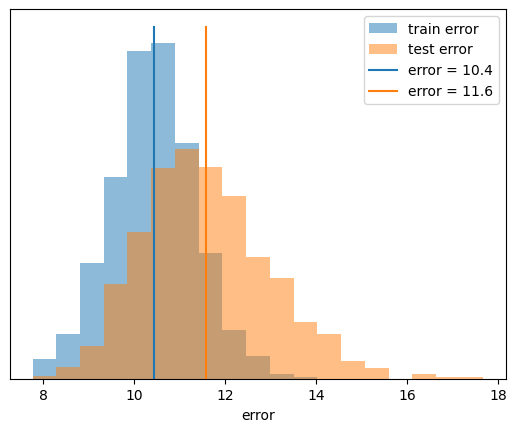

In [5]:
m = np.min([*train_errs, *test_errs])
M = np.max([*train_errs, *test_errs])
bins = np.linspace(m, M, 20)
plt.hist(train_errs, bins=bins, alpha=0.5, label="train error")
plt.hist(test_errs, bins=bins, alpha=0.5, label="test error")
ylim = plt.ylim()
plt.plot(
    [train_errs.mean(), train_errs.mean()],
    ylim,
    color="C0",
    label=f"error = {train_errs.mean():.1f}",
)
plt.plot(
    [test_errs.mean(), test_errs.mean()],
    ylim,
    color="C1",
    label=f"error = {test_errs.mean():.1f}",
)
plt.yticks([])
plt.xlabel("error")
plt.legend()
plt.show()

### Cross-validation for estimating prediction error

![](cross_validation.png)

(Figure cropped from [the scikit-learn cross-validation docs](https://scikit-learn.org/stable/modules/cross_validation.html).)

#### Example: `auto` data

In [6]:
def cross_val_splits(X: pd.DataFrame, y: pd.Series, n_folds=5, random_state=None):
    assert X.index is y.index
    index = X.index
    test_size = len(X) // n_folds
    rng = np.random.default_rng(random_state)
    permuted_index = index[rng.permuted(index)]
    for j in range(n_folds):
        test_mask = index.isin(permuted_index[j * test_size : (j + 1) * test_size])
        yield X[~test_mask], X[test_mask], y[~test_mask], y[test_mask]

In [151]:
X = auto.copy()
y = X.pop("mpg")

r = 100
n_folds = 5

train_errs = np.zeros((r, n_folds))
test_errs = np.zeros((r, n_folds))

model = LinearRegression()

for i in range(r):
    splits = cross_val_splits(X, y, n_folds=n_folds)
    for j, (X_train, X_test, y_train, y_test) in enumerate(splits):
        model.fit(X_train, y_train)
        train_errs[i, j] = mean_squared_error(y_train, model.predict(X_train))
        test_errs[i, j] = mean_squared_error(y_test, model.predict(X_test))


print(train_errs.mean(axis=1).mean(), train_errs.mean(axis=1).std())
print(test_errs.mean(axis=1).mean(), test_errs.mean(axis=1).std())

train_errs = train_errs.ravel()
test_errs = test_errs.ravel()

10.60775757672236 0.031382450563941795
11.375812655514062 0.23535005982014423


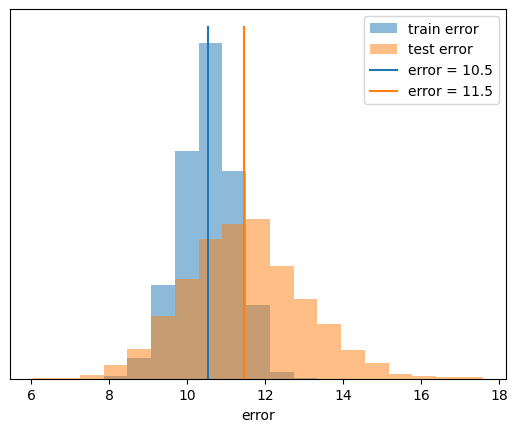

In [8]:
m = np.min([*train_errs, *test_errs])
M = np.max([*train_errs, *test_errs])
bins = np.linspace(m, M, 20)
plt.hist(train_errs, bins=bins, alpha=0.5, label="train error")
plt.hist(test_errs, bins=bins, alpha=0.5, label="test error")
ylim = plt.ylim()
plt.plot(
    [train_errs.mean(), train_errs.mean()],
    ylim,
    color="C0",
    label=f"error = {train_errs.mean():.1f}",
)
plt.plot(
    [test_errs.mean(), test_errs.mean()],
    ylim,
    color="C1",
    label=f"error = {test_errs.mean():.1f}",
)
plt.yticks([])
plt.xlabel("error")
plt.legend()
plt.show()

### Predictive error as metric for model comparison

In [50]:
def make_data_maker(random_state=42):
    rng = np.random.default_rng(random_state)

    def make_data(n):  # sample from p
        X = rng.uniform(size=(n, 1))
        y = rng.normal(size=n)
        return X, y

    return make_data

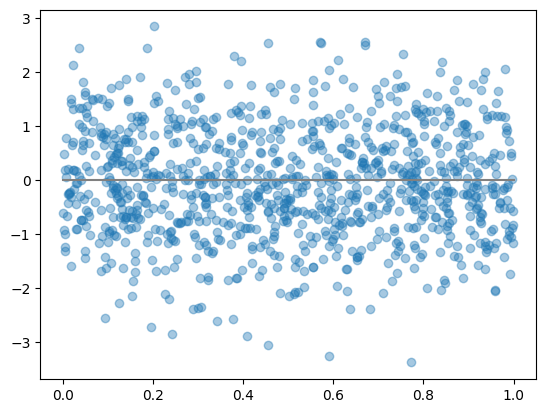

In [57]:
make_data = make_data_maker()
X_test, y_test = make_data(1_000_000)
plt.plot([0, 1], [0, 0], color="grey")
plt.scatter(X_test.squeeze()[:1000], y_test[:1000], alpha=0.4)

In [60]:
n = 5
r = 1000


test_errs = np.zeros(r)
triv_train_errs = np.zeros(r)
triv_test_errs = np.zeros(r)

model = LinearRegression()

for i in range(r):
    X_train, y_train = make_data(n)
    model.fit(X_train, y_train)
    train_errs[i] = mean_squared_error(y_train, model.predict(X_train))
    triv_train_errs[i] = mean_squared_error(y_train, np.zeros_like(y_train))
    test_errs[i] = mean_squared_error(y_test, model.predict(X_test))
    triv_test_errs[i] = mean_squared_error(y_test, np.zeros_like(y_test))

In [91]:
print(f"triv_train_errs.mean() = {triv_train_errs.mean():.2f}")
print(f"train_errs.mean() = {train_errs.mean():.2f}")

print(f"triv_test_err = {mean_squared_error(y_test, np.zeros_like(y_test)):.2f}")
print(f"test_errs.mean() = {test_errs.mean():.2f}")

triv_train_errs.mean() = 0.98
train_errs.mean() = 0.58
triv_test_err = 1.00
test_errs.mean() = 1.79


In [97]:
n = 5
r = 1000

Z_train = np.zeros((n, 1))
Z_test = np.zeros((1_000_000, 1))

reduced_model = LinearRegression()
reduced_train_errs = np.zeros(r)
reduced_test_errs = np.zeros(r)

model = LinearRegression()
train_errs = np.zeros(r)
test_errs = np.zeros(r)


for i in range(r):
    X_train, y_train = make_data(n)
    reduced_model.fit(Z_train, y_train)
    reduced_train_errs[i] = mean_squared_error(y_train, reduced_model.predict(Z_train))
    reduced_test_errs[i] = mean_squared_error(y_test, reduced_model.predict(Z_test))

    model.fit(X_train, y_train)
    train_errs[i] = mean_squared_error(y_train, model.predict(X_train))
    test_errs[i] = mean_squared_error(y_test, model.predict(X_test))

In [98]:
print(reduced_test_errs.mean(), test_errs.mean())
print(reduced_train_errs.mean(), train_errs.mean())

1.205026542362912 1.6675170823057843
0.7782218936969835 0.5854092242934449


In [103]:
from data335 import lm, compare_fits

n = 5
r = 10000

pvals = np.zeros(r)


for i in range(r):
    X_train, y_train = make_data(n)
    df = {"x": X_train.squeeze(), "y": y_train}
    reduced_fit = lm("y ~ 1", df)
    fit = lm("y ~ 1 + x", df)
    comp = compare_fits(fit, reduced_fit)
    pvals[i] = comp.ftest.pval

Text(0.5, 1.0, 'Distribution of $F$-test $p$-values (10000 replicates)')

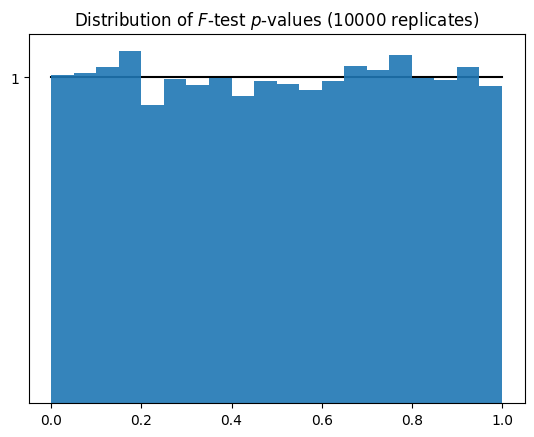

In [ ]:
plt.plot([0, 1], [1, 1], "k", zorder=-1)
plt.hist(pvals, density=True, bins=20, alpha=0.9)
plt.yticks([1])
plt.title("Distribution of $F$-test $p$-values (10000 replicates)")

In [134]:
def loocv_splits(X: pd.DataFrame, y: pd.Series, random_state=None):
    n = len(X)
    assert len(y) == n
    train_mask = np.ones(n, dtype=bool)
    test_mask = np.zeros(n, dtype=bool)
    for i in range(n):
        train_mask[i] = False
        test_mask[i] = True
        yield X[train_mask], X[test_mask], y[train_mask], y[test_mask]
        train_mask[i] = True
        test_mask[i] = False

In [137]:
X = auto.copy()
y = X.pop("mpg")

for X_train, X_test, y_train, y_test in loocv_splits(X, y):
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    break

(391, 8) (1, 8) (391,) (1,)


In [ ]:
X = auto.copy()
y = X.pop("mpg")

n = len(X)
train_errs = np.zeros(n)
test_errs = np.zeros(n)

model = LinearRegression()

splits = loocv_splits(X, y)
for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
    model.fit(X_train, y_train)
    train_errs[i] = mean_squared_error(y_train, model.predict(X_train))
    test_errs[i] = mean_squared_error(y_test, model.predict(X_test))

train_errs = train_errs.ravel()
test_errs = test_errs.ravel()

In [152]:
print(train_errs.mean(), train_errs.std())
print(test_errs.mean(), test_errs.std())

10.60775757672236 0.5110804853995253
11.375812655514062 2.1384403641754868


In [155]:
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,european,japanese
0,18.0,8,307.0,130.0,3504,12.0,70,False,False
1,15.0,8,350.0,165.0,3693,11.5,70,False,False
2,18.0,8,318.0,150.0,3436,11.0,70,False,False
3,16.0,8,304.0,150.0,3433,12.0,70,False,False
4,17.0,8,302.0,140.0,3449,10.5,70,False,False
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86.0,2790,15.6,82,False,False
388,44.0,4,97.0,52.0,2130,24.6,82,True,False
389,32.0,4,135.0,84.0,2295,11.6,82,False,False
390,28.0,4,120.0,79.0,2625,18.6,82,False,False


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

X = auto.copy()
y = X.pop("mpg")
p2 = PolynomialFeatures(2)
XX = p2.fit_transform(X)
p3 = PolynomialFeatures(3)
XXX = p3.fit_transform(X)

model = LinearRegression()
cv_err = -cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")
print(cv_err.mean())

cv_err = -cross_val_score(model, XX, y, cv=5, scoring="neg_mean_squared_error")
print(cv_err.mean())

cv_err = -cross_val_score(model, XXX, y, cv=5, scoring="neg_mean_squared_error")
print(cv_err.mean())

15.102467600774682
12.424037504068476
138.23978704284664


In [234]:
from sklearn.model_selection import KFold

X = auto[["weight"]]
y = auto["mpg"]

weight = auto["weight"]
weight_squared = weight**2
weight_squared.name = "weight_squared"
XX = pd.concat([weight, weight_squared], axis=1)

r = 100
linear_errs = np.zeros((r, 5))
quad_errs = np.zeros((r, 5))

for i in range(r):
    model = LinearRegression()
    linear_errs[i] = -cross_val_score(
        model,
        X,
        y,
        cv=KFold(n_splits=5, shuffle=True),
        scoring="neg_mean_squared_error",
    )

    model = LinearRegression()
    quad_errs[i] = -cross_val_score(
        model,
        XX,
        y,
        cv=KFold(n_splits=5, shuffle=True),
        scoring="neg_mean_squared_error",
    )

print(linear_errs.mean(), quad_errs.mean())

18.858705849862787 17.54553324050963


In [232]:
kfold = KFold(shuffle=True)
for I in kfold.split(X, y):
    print(I)
    break

(array([  0,   1,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        31,  32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  44,  45,
        46,  47,  48,  49,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  62,  64,  65,  66,  68,  69,  72,  76,  77,  79,  80,  81,
        85,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 102, 103, 104, 105, 107, 108, 109, 110, 112, 113, 114, 115,
       116, 117, 119, 120, 121, 123, 124, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 176,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 192,
       193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 205, 207, 208,
       209, 210, 211, 214, 217, 218, 221, 222, 223, 224, 225, 2

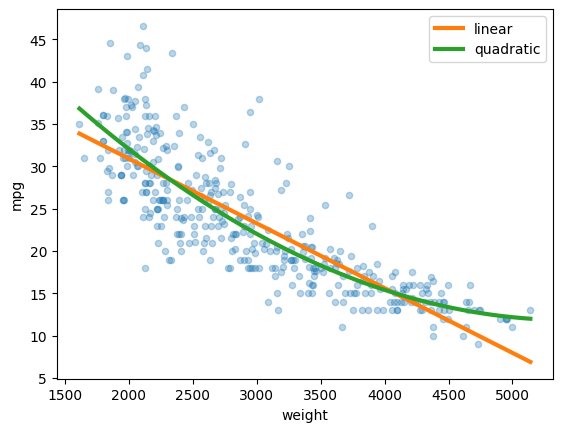

In [212]:
W = np.zeros((100, 2))
W[:, 0] = np.linspace(weight.min(), weight.max(), 100)
W[:, 1] = W[:, 0] ** 2

auto.plot.scatter("weight", "mpg", alpha=0.3)

model.fit(X.to_numpy(), y)
y_pred = model.predict(W[:, 0].reshape(-1, 1))
plt.plot(W[:, 0], y_pred, color="C1", lw=3, label="linear")

model.fit(XX.to_numpy(), y)
y_pred = model.predict(W)
plt.plot(W[:, 0], y_pred, color="C2", lw=3, label="quadratic")

plt.legend()
plt.show()

In [197]:
ws

array([1613.        , 1684.97959184, 1756.95918367, 1828.93877551,
       1900.91836735, 1972.89795918, 2044.87755102, 2116.85714286,
       2188.83673469, 2260.81632653, 2332.79591837, 2404.7755102 ,
       2476.75510204, 2548.73469388, 2620.71428571, 2692.69387755,
       2764.67346939, 2836.65306122, 2908.63265306, 2980.6122449 ,
       3052.59183673, 3124.57142857, 3196.55102041, 3268.53061224,
       3340.51020408, 3412.48979592, 3484.46938776, 3556.44897959,
       3628.42857143, 3700.40816327, 3772.3877551 , 3844.36734694,
       3916.34693878, 3988.32653061, 4060.30612245, 4132.28571429,
       4204.26530612, 4276.24489796, 4348.2244898 , 4420.20408163,
       4492.18367347, 4564.16326531, 4636.14285714, 4708.12244898,
       4780.10204082, 4852.08163265, 4924.06122449, 4996.04081633,
       5068.02040816, 5140.        ])

In [241]:
ns = np.arange(5, 50, 2)
rng = np.random.default_rng(42)

X_test = rng.normal(size=(1_000_000, 1))
y_test = rng.normal(size=1_000_000)

err_null = np.zeros((r, len(ns)))
err_full = np.zeros((r, len(ns)))

r = 100
model = LinearRegression()
for i in range(r):
    for j, n in enumerate(ns):
        X_train = rng.normal(size=(n, 1))
        y_train = rng.normal(size=n)
        model.fit(X_train, y_train)
        err_null[i, j] = mean_squared_error(
            y_test, y_train.mean() * np.ones_like(y_test)
        )
        err_full[i, j] = mean_squared_error(y_test, model.predict(X_test))

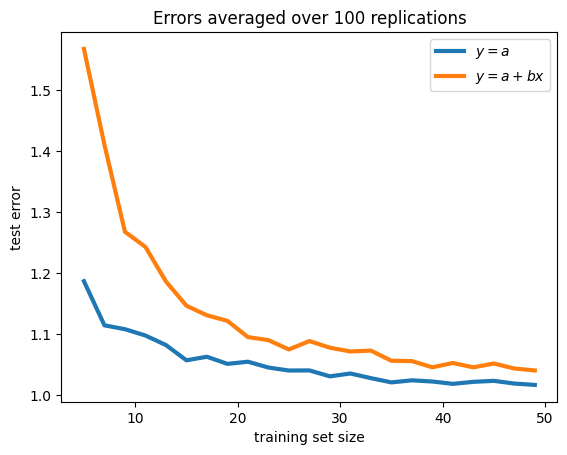

In [247]:
plt.plot(ns, err_null.mean(axis=0), lw=3, label="$y=a$")
plt.plot(ns, err_full.mean(axis=0), lw=3, label="$y=a + bx$")
plt.xlabel("training set size")
plt.ylabel("test error")
plt.title("Errors averaged over 100 replications")
plt.legend()

In [238]:
err_full.mean(axis=0)

array([2.06342945, 1.24693144, 1.1501387 , 1.12350516, 1.09114276,
       1.07693428, 1.06226318, 1.04860913, 1.04222789, 1.03589274,
       1.03256946, 1.03666278, 1.02714416, 1.02863167, 1.03030645,
       1.02552461, 1.02396638, 1.02356308, 1.02244102])